### RAOP Baseline Notebook

Jose Torres, Shane Kramer, Monali Narayanaswami, Sybil Santos-Burgan

Semester: Spring 2022

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import *
import nltk

import json 
import pandas as pd 
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#Load training data
with open('../data/random-acts-of-pizza/train.json') as f:
    train_json = json.load(f)
    
# Load test data
with open('../data/random-acts-of-pizza/test.json') as f:
    test_json = json.load(f)


### Clean Input

In [4]:
train = json_normalize(train_json)
test = json_normalize(test_json)




### Divide data into training and dev sets

In [5]:
# train_data = train[:2800]
# train_labels = train[:2800]['requester_received_pizza']
# test_data = test[:]

# dev_data = train[2800:]
# dev_labels = train[2800:]['requester_received_pizza']





train_data, test_data, train_labels, test_labels = train_test_split(train, train['requester_received_pizza'], test_size=0.25,random_state=0)

train_data, dev_data, train_labels, dev_labels = train_test_split(train_data, train_labels, test_size=0.25,random_state=0)

train_data_title = train_data['request_title']
dev_data_title = dev_data['request_title']
test_data_title = test_data['request_title']
train_received_pizza = train_data['requester_received_pizza']
dev_received_pizza = dev_data['requester_received_pizza']

# Can configure the list below to filter columns from original training data set
test_cols = ['request_text', 'request_number_of_comments_at_retrieval', 'requester_received_pizza']
filtered_df = train_data[test_cols]
filtered_df_dev = dev_data[test_cols]
filtered_df_test = test_data[test_cols]

# Add word count column
filtered_df['request_text_count'] = filtered_df['request_text'].str.count(' ') + 1
filtered_df_dev['request_text_count'] = filtered_df_dev['request_text'].str.count(' ') + 1
filtered_df_test['request_text_count'] = filtered_df_test['request_text'].str.count(' ') + 1

# Now need to split into features and targets
feature_cols = ['request_text_count', 'request_number_of_comments_at_retrieval']
X_train = filtered_df[feature_cols]
Y_train = filtered_df.requester_received_pizza
X_dev = filtered_df_dev[feature_cols]
Y_dev = filtered_df_dev.requester_received_pizza

X_test = filtered_df_test[feature_cols]
Y_test = filtered_df_test.requester_received_pizza


<ipython-input-5-ad3163804226>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['request_text_count'] = filtered_df['request_text'].str.count(' ') + 1
<ipython-input-5-ad3163804226>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_dev['request_text_count'] = filtered_df_dev['request_text'].str.count(' ') + 1
<ipython-input-5-ad3163804226>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

### Examine Data

In [6]:
print('training data shape:', train_data.shape)
print('training label shape:', train_labels.shape)
print('dev data shape:',     dev_data.shape)
print('dev label shape:',      dev_labels.shape)
print('test data shape:', test_data.shape)
print('test label shape:', test_labels.shape)
print('train_received_pizza:', train_received_pizza.shape)
print('dev_received_pizza:', dev_received_pizza.shape)
print('filtered_df shape:', X_train.shape)
print('filtered_df label shape:', Y_train.shape)
print('filtered_df dev shape:', X_dev.shape)
print('filtered_df dev label shape:', Y_dev.shape)
print('filtered_df dev shape:', X_test.shape)
print('filtered_df dev label shape:', Y_test.shape)

#print('training data shape title:',      train_data_title.shape)
#print('dev data shape title:',      dev_data_title.shape)

training data shape: (2272, 32)
training label shape: (2272,)
dev data shape: (758, 32)
dev label shape: (758,)
test data shape: (1010, 32)
test label shape: (1010,)
train_received_pizza: (2272,)
dev_received_pizza: (758,)
filtered_df shape: (2272, 2)
filtered_df label shape: (2272,)
filtered_df dev shape: (758, 2)
filtered_df dev label shape: (758,)
filtered_df dev shape: (1010, 2)
filtered_df dev label shape: (1010,)



For first 5 training examples, print the title of request

In [7]:
def display_request(num_examples=5):

    for i in range(num_examples):
        print(train_data.iloc[i]['request_title']) 
        print(train_data.iloc[i]['request_text'])
        print('Received Pizza: ', train_data.iloc[i]['requester_received_pizza']) 
        print('\n')  

        
display_request(5)

(Request) Really high right now, would love some pizza.
I'm really high right now and love some pizza.

Morning after edit because I couldn't edit on my phone: Thanks /u/unaspirateur for the delicious noms.
Received Pizza:  True


(Request) family of 5 here and all we have to eat is ramen. Girlfriend just had a miscarriage and I think pizza would cheer her up a bit
I just got a job yesterday but I wont have money for the next 2 weeks for food. Thank you so much in advance for anyone who helps.

Also since I should clarify, the family of five is her and her mom, step dad, step sister, and me. I live here out of necessity since living conditions at my grandmother's house became unlivable for me. 
Received Pizza:  False


[Request] hungry family in NJ
Hello everyone! I found out about this website from a friend who heard of it thru WUAH! Im hoping I could get some help tonight for pizza for my family. I am broke until tomorrows payday thanks to a flat tire that i HAD to replace. We dont h

<AxesSubplot:xlabel='requester_received_pizza'>

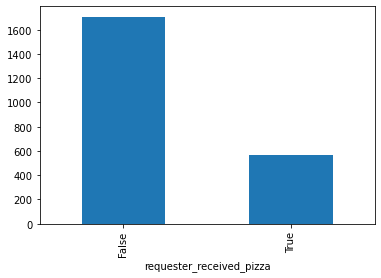

In [8]:
#Baseline accuracy
train_data.groupby('requester_received_pizza').size().plot(kind = "bar")


### Classification

In [9]:
# Create and train model using train data
logreg = LogisticRegression()
logreg.fit(X_train,Y_train)
Y_pred = logreg.predict(X_dev)

# Output results
print("Accuracy:",metrics.accuracy_score(Y_dev, Y_pred))
print("Precision:",metrics.precision_score(Y_dev, Y_pred))
print("Recall:",metrics.recall_score(Y_dev, Y_pred))

Accuracy: 0.7453825857519789
Precision: 0.4444444444444444
Recall: 0.17297297297297298


In [10]:
# Run model against test data
Y_test_pred = logreg.predict(X_test)

In [11]:
# Look at confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, Y_test_pred)
cnf_matrix

array([[722,  43],
       [205,  40]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

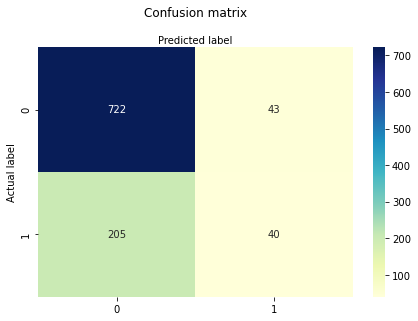

In [12]:
# Plot results
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

# def text_preprocessor(text):
#     text = text.lower()
#     text = re.sub("\W",' ',text) # replace non-alphanumeric
#     text = re.sub("_",' ',text) # replace non-alphanumeric
#     text = re.sub('\n', '', text)   
#     return text

#vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', preprocessor=text_preprocessor)
vectorizer = CountVectorizer(ngram_range=(2, 2))

train_vector = vectorizer.fit_transform(train_data_title)

print('Size of vocabulary: ', train_vector.shape[1])

dev_vector = vectorizer.transform(dev_data_title)

#Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score
print('\n***  Naive Bayes model ***') 


mnb = MultinomialNB(alpha = 0.5)
mnb.fit(train_vector, train_received_pizza)

#Evaluate performance on the dev set.
pred_mnb = mnb.predict(dev_vector)
score = metrics.f1_score(dev_labels, pred_mnb, average="weighted")
print(f"a = 0.5, f1 score = {score}")

accuracy, precision, recall, f1 = get_metrics(dev_labels, pred_mnb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Size of vocabulary:  13633

***  Naive Bayes model ***
a = 0.5, f1 score = 0.6650147039376326
accuracy = 0.714, precision = 0.644, recall = 0.714, f1 = 0.665


In [14]:
def text_preprocessor(text):
    text = text.lower()
    text = re.sub("\W",' ',text) # replace non-alphanumeric
    text = re.sub("_",' ',text) # replace non-alphanumeric
    text = re.sub('\n', '', text)
    text = text.replace('\[request\]','') 
    text = text.replace('request','')
    text = text.replace('\[request\]','')
    
    return text

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', preprocessor=text_preprocessor)
train_vector = vectorizer.fit_transform(train_data_title)
dev_vector = vectorizer.transform(dev_data_title)
lr = LogisticRegression(C=.5, solver="liblinear", multi_class="auto")
lr.fit(train_vector, train_received_pizza)

pred_lr = lr.predict(dev_vector)
score = metrics.f1_score(dev_labels, pred_lr, average="weighted")
print('\n***  Logistic Regression model ***') 
print(f"a = 0.5, f1 score = {score}")

accuracy, precision, recall, f1 = get_metrics(dev_labels, pred_lr)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))        



***  Logistic Regression model ***
a = 0.5, f1 score = 0.6570666781667993
accuracy = 0.759, precision = 0.817, recall = 0.759, f1 = 0.657


In [15]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'top':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vectorizer, lr, 10)
top_words = importance[0]['top']

#most important words 
top_words

[(0.5998178508088684, 'usa love'),
 (0.6101905219016865, 'pizza read'),
 (0.6121620961856307, 'pizza tonight'),
 (0.6642899851120605, 'little brother'),
 (0.6931812177661318, 'nj pizza'),
 (0.6986593209829385, 'single mother'),
 (0.745727104184074, 'los angeles'),
 (0.7467851947848518, 'usa pizza'),
 (0.7663141813256859, 'needs food'),
 (0.7877480561371513, 'pregnant hungry')]

In [16]:
#least important words 
bottom_words = importance[0]['bottom']
bottom_words

[(-0.4276915197942441, 'looking good'),
 (-0.4456072749192251, 'pizza help'),
 (-0.46521476193257183, 'pizza today'),
 (-0.4744089112139644, 'studying finals'),
 (-0.4805111890658747, 'california usa'),
 (-0.4899183003262267, 'need pizza'),
 (-0.49656623600327976, 'love pizza'),
 (-0.5048703303781503, 'just moved'),
 (-0.5510401909311087, 'really appreciate'),
 (-0.6587633194784812, 'like pizza')]